In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

## <center> GRU Architecture </center>
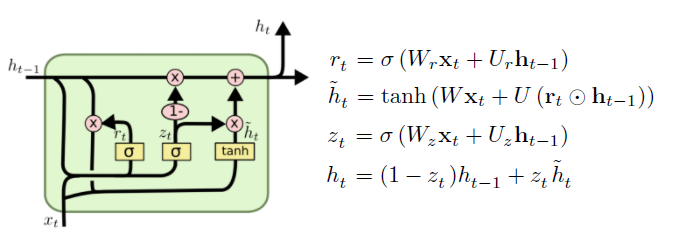 

## RNN's Architecture V/S GRU's Architecture 

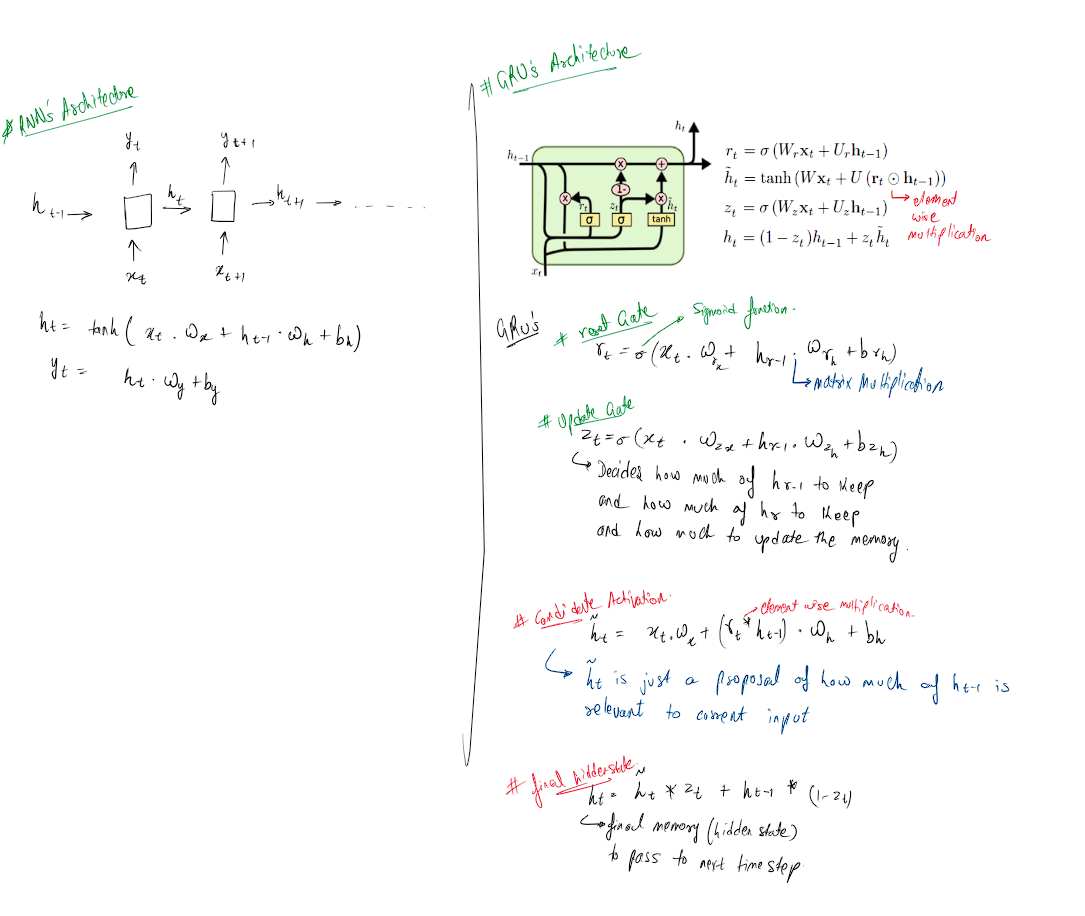

## Dataset Preperation (x_train and y_train)

In [2]:
# Load all the words from the '.txt' file
words = open('names.txt', mode = 'r', encoding='utf-8').read().splitlines()

# Encoder and Decoder
# A little bit change in the Token Mapping
# I'll use:
# - 0 to denote ---> <PAD> tokens
# - 1 to denote ---> '.' (end token)
# - and all characters from [2, .., 28]

chars = sorted(list(set(''.join(words))))

# Reserve 0 for PAD token
stoi = {c: i+2 for i, c in enumerate(chars)}  # alphabet starts at index 2
stoi['.'] = 1   # END token
stoi['<PAD>'] = 0   # padding token
itos = {i: c for c, i in stoi.items()}

def encode_word(word, stoi):
    return [stoi[c] for c in word] + [stoi['.']]

def decode_indices(indices, itos):
    return [itos[i.item()] for i in indices]

encoded = [encode_word(w, stoi) for w in words]
max_len = max(len(seq) for seq in encoded)

def pad_sequences(sequences, max_len):
    X, Y = [], []

    for seq in sequences:
        x = seq[:-1]                        # all but last char
        y = seq[1:]                         # all but first char

        # padding
        x += [0] * (max_len - len(x))
        y += [-100] * (max_len - len(y))

        X.append(x)
        Y.append(y)

    return torch.tensor(X), torch.tensor(Y)

def generate_dataset():
    words = open('names.txt', mode = 'r', encoding='utf-8').read().splitlines()
    encoded = [encode_word(w, stoi) for w in words]
    max_len = max(len(seq) for seq in encoded)
    x_tensor, y_tensor = pad_sequences(encoded, max_len)
    return x_tensor, y_tensor

In [3]:
x_train, y_train = generate_dataset()

## Custom Framework: Similar to PyTorch's API

In [4]:
class Embeddings:
    def __init__(self, embd_dim, n_classes):
        self.embd_dim = embd_dim
        self.n_classes = n_classes
        self.embd_matrix = torch.nn.Parameter(torch.randn(self.n_classes, self.embd_dim, requires_grad=True))
    
    def forward(self, x):
        return self.embd_matrix[x]
    
    def parameters(self):
        return [self.embd_matrix]
    
    def __call__(self, x):
        return self.forward(x)
    
    def to(self, device):
        self.embd_matrix = torch.nn.Parameter(self.embd_matrix.to(device))
        return self
    
    def named_parameters(self, prefix="embeddings"):
        return {f"{prefix}.embd_matrix": self.embd_matrix}


class Linear:
    def __init__(self, *, in_features, out_features):
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.nn.Parameter(torch.randn(in_features, out_features))
        self.bias = torch.nn.Parameter(torch.randn(out_features,))
    
    def forward(self, x):
        return x @ self.weight + self.bias
    
    def __call__(self, x):
        return self.forward(x)
    
    def parameters(self):
        return [self.weight] + [self.bias]
    
    def to(self, device):
        self.weight = torch.nn.Parameter(self.weight.to(device))
        self.bias = torch.nn.Parameter(self.bias.to(device))
        return self
    
    def named_parameters(self, prefix="linear"):
        return {
            f"{prefix}.weight": self.weight,
            f"{prefix}.bias": self.bias
        }

class GRU_cell:
    def __init__(self, embd_dim, hidden_dim, n_classes = None, name="gru_cell"):
        self.name = name
        # NOTE-1: I'm using weight_x instead of weight_hx
        # NOTE-2: I'm using weight_h instead of weight_hh
        # Reason: To keep same naming convention as of RNN's
        self.weight_x = torch.nn.Parameter(torch.randn(embd_dim, hidden_dim))
        self.weight_h = torch.nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.bias_h = torch.nn.Parameter(torch.zeros(hidden_dim))

        # Reset and Update Gate Specific Parameters
        self.weight_rx = torch.nn.Parameter(torch.randn(embd_dim, hidden_dim))
        self.weight_rh = torch.nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.bias_r = torch.nn.Parameter(torch.randn(hidden_dim))
        self.weight_zh = torch.nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.weight_zx = torch.nn.Parameter(torch.randn(embd_dim, hidden_dim))
        self.bias_z = torch.nn.Parameter(torch.randn(hidden_dim))

        # Tanh-saturation solution: Reduces saturation and improves learnability

        # input projections
        torch.nn.init.xavier_uniform_(self.weight_x)
        torch.nn.init.xavier_uniform_(self.weight_rx)
        torch.nn.init.xavier_uniform_(self.weight_zx)

        # recurrent projections
        torch.nn.init.orthogonal_(self.weight_h)
        torch.nn.init.orthogonal_(self.weight_rh)
        torch.nn.init.orthogonal_(self.weight_zh)

        # biases
        torch.nn.init.zeros_(self.bias_h)
        torch.nn.init.zeros_(self.bias_r)
        torch.nn.init.zeros_(self.bias_z)

        self.return_logits = (n_classes is not None)
        self.layer_norm = LayerNorm1d()
        if self.return_logits:
            self.weight_y = torch.nn.Parameter(torch.randn(hidden_dim, n_classes))
            self.bias_y = torch.nn.Parameter(torch.randn(n_classes))
            torch.nn.init.xavier_uniform_(self.weight_y)
            torch.nn.init.zeros_(self.bias_y)
    
    def forward(self, x, h_prev):
        """
        --> A proposed update → candidate (h̃_t)
        --> A decision gate → update gate (z_t)
        --> A final controlled update → h_t

        NOTE:   1. Reset Gate Filters h_prev
                    - r_t = sigmoid( ( (x_t @ W_rx) + (h_prev @ W_rh) + b_r) )
                2. Apply filter to h_prev
                    - filtered_h_prev = r_t * h_prev [NOTE: (where * is element-wise multiplication)]
                        - Meaning:
                            - If r_t ≈ 0 → ignore old memory when forming candidate
                            - If r_t ≈ 1 → use old memory fully
                3. Compute candidate
                    - h̃_t = tanh( ( (x_t @ W_hx) + (filtered_h_prev @ W_hh) + b_h) )
                        - Meaning: 
                            - This produces a new memory proposal: A proposed update
                4. Final hidden state
                    - h_t = (1 - z_t) * h_prev + z_t * h̃_t [NOTE: (where * is element-wise multiplication)]
        """
        # Gates
        z_t = torch.sigmoid(x @ self.weight_zx + h_prev @ self.weight_zh + self.bias_z)
        r_t = torch.sigmoid(x @ self.weight_rx + h_prev @ self.weight_rh + self.bias_r)

        # Candidate: It is just a suggestion from the network.

        # h_tilde: It is not the final output, its just a suggestion from the network and it tells us,
        # --> What the new hidden state would be if we decided to fully update memory at this timestep
        # --> If we want to keep newly computed memory, then z_t = 1.
        # --> If we want to keep old memory, then z_t = 0.
        # So basically, z_t controls how much of this candidate actually enters final memory.

        h_tilde_pre = x @ self.weight_x + ((h_prev * r_t) @ self.weight_h) + self.bias_h
        h_tilde = torch.tanh(self.layer_norm(h_tilde_pre))

        # Final hidden state
        h = (1 - z_t) * h_prev +  z_t * h_tilde

        if self.return_logits:
            y = h @ self.weight_y + self.bias_y
            return h, y
        return h
    
    def __call__(self, x, h_prev): 
        return self.forward(x, h_prev)
    
    def parameters(self):
        params = [self.weight_x, self.weight_h, self.bias_h, self.weight_rx, self.weight_rh, self.bias_r, self.weight_zh, self.weight_zx, self.bias_z]
        params += self.layer_norm.parameters()
        if self.return_logits:
            params += [self.weight_y, self.bias_y]
        return params
    
    def to(self, device):
        self.weight_x = torch.nn.Parameter(self.weight_x.to(device))
        self.weight_h = torch.nn.Parameter(self.weight_h.to(device))
        self.bias_h   = torch.nn.Parameter(self.bias_h.to(device))
        self.weight_rx = torch.nn.Parameter(self.weight_rx.to(device))
        self.weight_rh = torch.nn.Parameter(self.weight_rh.to(device))
        self.bias_r = torch.nn.Parameter(self.bias_r.to(device))
        self.weight_zh = torch.nn.Parameter(self.weight_zh.to(device))
        self.weight_zx = torch.nn.Parameter(self.weight_zx.to(device))
        self.bias_z = torch.nn.Parameter(self.bias_z.to(device))
        if self.return_logits:
            self.weight_y = torch.nn.Parameter(self.weight_y.to(device))
            self.bias_y   = torch.nn.Parameter(self.bias_y.to(device))
        return self
    
    def named_parameters(self, prefix=None):
        name = prefix or self.name
        params = {
            f"{name}.weight_x": self.weight_x,
            f"{name}.weight_h": self.weight_h,
            f"{name}.bias_h": self.bias_h,
            f"{name}.weight_rx": self.weight_rx,
            f"{name}.weight_rh": self.weight_rh,
            f"{name}.bias_r": self.bias_r,
            f"{name}.weight_zx": self.weight_zx,
            f"{name}.weight_zh": self.weight_zh,
            f"{name}.bias_z": self.bias_z,
        }
        # layer norm params
        ln_params = self.layer_norm.named_parameters(prefix=f"{name}.layer_norm")
        params.update(ln_params)
        if self.return_logits:
            params[f"{name}.weight_y"] = self.weight_y
            params[f"{name}.bias_y"]   = self.bias_y
        return params

class GRULayer:
    def __init__(self, embd_dim, hidden_dim, n_classes = None, name="gru_layer"):
        self.name = name
        self.grucell = GRU_cell(embd_dim, hidden_dim, n_classes)
        self.return_logits = (n_classes is not None)
    
    def forward(self, x, prev_hidden = None):
        # x.shape = (batch_size, block_size, embd_dim) --> (2, 8, 15)
        batch_size, block_size, _ = x.shape
        device = x.device

        if prev_hidden is None:
            prev_hidden = torch.zeros(batch_size, self.grucell.weight_h.shape[0]).to(device) # since weight_h is (hidden_dim, hidden_dim)
        
        hidden_states = []
        outputs = []
        h = prev_hidden
        for t in range(block_size):
            x_t = x[:, t, :]
            output = self.grucell(x_t, h)
            if self.return_logits:
                h, y = output
                outputs.append(y) # here y.shape = (batch_size, n_classes)
            else:
                h = output
            
            hidden_states.append(h)
        
        # Convert list --> tensor format: (batch, block_size, dim) --> for each example in a batch we now computed hidden_states and outputs for each character in a block_size (at each timesetp)
        hidden_states = torch.stack(hidden_states, dim=1)
        if self.return_logits:
            outputs = torch.stack(outputs, dim=1)  # (batch, seq_len, n_classes)
            return hidden_states, outputs
        
        return hidden_states
    
    def __call__(self, x, h_prev=None):
        return self.forward(x, h_prev)
    
    def parameters(self):
        return self.grucell.parameters()
    
    def to(self, device):
        self.grucell.to(device)
        return self
    
    def named_parameters(self, prefix=None):
        name = prefix or self.name
        return self.grucell.named_parameters(prefix=f"{name}.cell")



class Flatten:
    def forward(self, x):
        return x.view(x.shape[0], -1)
    
    def __call__(self, x):
        return self.forward(x)
    
    def parameters(self):
        return []
    
    def to(self, device):
        return self


class Sequential:
    def __init__(self, layers):
        self.layers = layers
        # Model Configuration
        self.embd_dim = None
        self.n_classes = None
        self.in_features = None
        self.out_features = None
        for layer in self.layers:
            if isinstance(layer, Embeddings):
                self.embd_dim = layer.embd_dim
                self.n_classes = layer.n_classes
                break
        for layer in self.layers:
            if isinstance(layer, GRULayer):
                self.in_features = layer.grucell.weight_x.shape[0]
                self.out_features = layer.grucell.weight_h.shape[0]
                break
    
    def named_parameters(self, prefix=""):
        params = {}
        for i, layer in enumerate(self.layers):
            if hasattr(layer, "named_parameters"):
                sub = layer.named_parameters(prefix=f"{prefix}layer_{i}")
                params.update(sub)
        return params
    
    def state_dict(self):
        return {k: v.data.clone() for k, v in self.named_parameters().items()}
    
    def load_state_dict(self, state, strict=True):
        current = self.named_parameters()
        missing = []
        for name, param in current.items():
            if name in state:
                param.data = state[name].to(param.data.device)
            else:
                missing.append(name)
        if strict and missing:
            raise KeyError(f"Missing keys in state_dict: {missing}")
        return missing
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def __call__(self, x):
        return self.forward(x)
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def to(self, device):
        for layer in self.layers:
            layer.to(device)
        return self


class Tanh:
    def forward(self, x):
        return torch.tanh(x)
    
    def __call__(self, x):
        return self.forward(x)
    
    def parameters(self):
        return []
    
    def to(self, device):
        return self

class Softmax:
    def forward(self, logits):
        exp_logits = torch.exp(logits)
        probs = exp_logits / exp_logits.sum(dim = -1, keepdim = True)
        return probs
    
    def __call__(self, logits):
        return self.forward(logits)
    
    def parameters(self):
        return []
    
    def to(self, device):
        return self


class CrossEntropyLoss:
    def __init__(self, ignore_index=-100):
        self.ignore_index = ignore_index

    def forward(self, logits, y_true):
        # logits: (batch, block_size, n_classes)
        # y_true: (batch, block_size)

        batch, block_size, n_classes = logits.shape

        # Flatten both for simplicity: (batch * block_size, n_classes)
        logits = logits.reshape(-1, n_classes)
        y_true = y_true.reshape(-1)

        # Create mask → which labels are valid?
        mask = (y_true != self.ignore_index)

        # Filter only valid positions
        logits = logits[mask]
        targets = y_true[mask]

        # Apply log-softmax for stability
        softmax = Softmax()
        probs = softmax(logits)
        loss = -(probs[torch.arange(0, len(probs)), targets].log().mean())
        return loss

    def __call__(self, logits, y_true):
        return self.forward(logits, y_true)
    
    def parameters(self):
        return []

class LayerNorm1d:
    def __init__(self, in_features = None, eps = 1e-8):
        self.in_features = in_features
        self.gamma = None
        self.beta = None
        self.eps = eps
    
    def _init_params(self, x, device):
        self.in_features = x.shape[-1]
        self.gamma = torch.nn.Parameter(torch.ones(1, self.in_features))
        self.beta = torch.nn.Parameter(torch.zeros(1, self.in_features))
        self.to(device)
    
    def forward(self, x):
        if self.gamma is None:
            device = x.device
            self._init_params(x, device)

        mean = x.mean(dim = -1, keepdim  = True)
        std = x.std(dim = -1, keepdim  = True)
        x_norm = ((x - mean) / (std + self.eps))
        return x_norm * self.gamma + self.beta # here * is Hadamard Multiplication (element-wise) multiplication
    
    def parameters(self):
        if self.gamma is None:
            return []
        return [self.gamma] + [self.beta]
    
    def to(self, device):
        if self.gamma is not None:
            self.gamma = torch.nn.Parameter(self.gamma.to(device))
            self.beta = torch.nn.Parameter(self.beta.to(device))
        return self
    
    def named_parameters(self, prefix="layernorm"):
        if self.gamma is None:
            return {}
        return {
            f"{prefix}.gamma": self.gamma,
            f"{prefix}.beta": self.beta
        }

    
    def __call__(self, x):
        return self.forward(x)

class GRUDiagnostics:
    def __init__(self):
        self.grad_history = []
        self.entropy_history = []
        self.weight_snapshots = []
        self.loss_curve = []

    def record_activations(self, hidden_states):
        # hidden_states: (batch, block_size, hidden_dim)
        hs = hidden_states.detach().cpu().numpy().flatten()
        self.activation_history.append(hs)

    def record_gradients(self, model):
        grad_vals = []
        for p in model.parameters():
            if p.grad is not None:
                grad_vals.append(p.grad.detach().abs().mean().cpu().item())
        self.grad_history.append(grad_vals)

    def record_weights(self, model):
        weights = []
        for p in model.parameters():
            weights.extend(p.detach().cpu().numpy().flatten())
        self.weight_snapshots.append(weights)

    def record_entropy(self, logits):
        probs = torch.softmax(logits, dim=-1)
        ent = -(probs * probs.log()).sum(dim=-1).detach().cpu().numpy().mean()
        self.entropy_history.append(ent)


## Register and Trainer for Model

In [5]:
class RegisterModel:
    def __init__(self, model_name, model_version, model, device, ignore_index=-100):
        self.model_name = model_name
        self.model_version = model_version
        self.model = model
        self.layers = self.model.layers
        self.embd_dim = self.model.embd_dim
        self.in_features = self.model.in_features
        self.out_features = self.model.out_features
        self.n_classes = self.model.n_classes
        self.loss_fn = CrossEntropyLoss(ignore_index)
        self.device = device

        # Move model to device before capturing params (important!)
        self.to(device)

        # Capture trainable parameters as a stable list referencing actual Parameter objects on device
        self.params = [p for p in self.model.parameters()]

        self.loss_history = []
        self.n_parameters = sum(p.nelement() for p in self.params)
        print(f"Model registered with {self.n_parameters} Parameters")

    def train(self, x, y, epochs, lr, diag, diag_interval = 100, patience=50, min_delta=1e-4, restore_best=True):
        self.diag = diag
        batch_size = 512
        self.summary(epochs, lr)
        print("-" * 100)

        initial_lr = lr
        best_loss = float("inf")
        best_weights = None
        wait = 0  # how many epochs with no improvement
        step = 0

        for epoch in range(epochs):
            lr = initial_lr * (0.95 ** (epoch / 200))
            total_loss = 0.0

            for i in range(0, len(x), batch_size):
                xb = x[i:i + batch_size]
                yb = y[i:i + batch_size]

                logits = self.model(xb)

                loss = self.loss_fn(logits=logits, y_true=yb)
                total_loss += loss.item()

                # Recording occasionally instead of always: To solve Memory Allocation Failed Error
                if step % diag_interval == 0:
                    self.diag.record_entropy(logits)

                # Reset gradients
                for p in self.params:
                    p.grad = None

                # Backprop
                loss.backward()

                # Recording occasionally instead of always: To solve Memory Allocation Failed Error
                if step % diag_interval == 0:
                    self.diag.record_gradients(self.model)
                    self.diag.record_weights(self.model)

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.params, 1.0)

                # Manual SGD update (guard if grad is None)
                for p in self.params:
                    p.data -= lr * p.grad

                step += 1

            # average loss per epoch
            num_batches = max((len(x) // batch_size), 1)
            avg_loss = total_loss / num_batches
            self.loss_history.append(avg_loss)
            self.diag.loss_curve.append(avg_loss)

            if epoch % 50 == 0:
                print(f"Epoch {epoch}/{epochs} | Loss: {avg_loss:.4f} | lr={lr:.5f}")

            # Early Stopping Mechanism
            if avg_loss < (best_loss - min_delta):
                best_loss = avg_loss
                wait = 0
                # store best-performing weights
                best_weights = {k: v.clone() for k, v in self.model.state_dict().items()}
            else:
                wait += 1

            if wait >= patience:
                print(f"\n>> Early stopping triggered at epoch {epoch} (patience={patience})")
                break

        # Restore best weights
        if restore_best and best_weights is not None:
            self.model.load_state_dict(best_weights)
            print(">> Restored best-performing weights.")

        return self.loss_history

    def to(self, device):
        # move model layers/parameters to device
        self.model.to(device)
        return self

    def __call__(self, x, y, epochs, lr, diag):
        return self.train(x, y, epochs, lr, diag)

    def summary(self, epochs, lr):
        print(f"Training {self.model_name} | {self.model_version} | Epochs = {epochs} | lr = {lr} | device = {self.device}")

        print("\n" + "=" * 90)
        print("Training Configuration Summary")
        print("=" * 90)
        print(f"Model Name        : {self.model_name}")
        print(f"Model Version     : {self.model_version}")
        print(f"Device            : {self.device}")
        print(f"Epochs            : {epochs}")
        print(f"Learning Rate     : {lr}")
        print("-" * 90)
        print("Model Hyperparameters:")
        print(f"  ├─ Embedding Dimension : {self.embd_dim}")
        print(f"  ├─ Number of Classes   : {self.n_classes}")
        print(f"  ├─ Input Dimension     : {self.in_features}")
        print(f"  └─ Hidden Dimension    : {self.out_features}")
        print("-" * 90)

        print("Model Architecture:")
        print("-" * 60)
        for layer in self.layers:
            layer_name = layer.__class__.__name__
            print(f"  └── {layer_name}()")
        print("-" * 60)

        print(f"Total Trainable Parameters : {self.n_parameters:,}")
        print("=" * 90 + "\n")

## Define Model Architecture

In [6]:
# -----------------------------------------------------------------------------------------------------------------
# Define Architecture of the Recurrent Neural Network: Model
n_classes = len(stoi)
embd_dim = 20
block_size = 32
hidden_dim = 128
softmax = Softmax()
loss_fn = CrossEntropyLoss()
diag_v1 = GRUDiagnostics()
diag_v2 = GRUDiagnostics()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# -----------------------------------------------------------------------------------------------------------------

# --------------------------------------------- Testing Different Model Designs -----------------------------------

# -----------------------------------------------------------------------------------------------------------------
# GRU Model version - 1:

GRU_v1 = Sequential([
    Embeddings(n_classes = n_classes, embd_dim = embd_dim),
    LayerNorm1d(), # LayerNorm BEFORE first GRU — stabilizes input space
    GRULayer(embd_dim, hidden_dim),        # GRU-1
    LayerNorm1d(),                         # Normalize GRU output
    GRULayer(hidden_dim, hidden_dim),      # GRU-2
    LayerNorm1d(),                         # Normalize GRU output                       
    Linear(in_features = hidden_dim, out_features=n_classes)
])
config_GRU_v1 = {
    "model_name": "GRU_v1",
    "n_classes": n_classes,
    "embd_dim": embd_dim,
    "block_size": block_size,
    "hidden_dim": hidden_dim,
    "architecture": "Embedding → LayerNorm → GRU_1 → LayerNorm → GRU_2 → LayerNorm → Linear"
}

# -----------------------------------------------------------------------------------------------------------------
# GRU Model version - 2:

GRU_v2 = Sequential([
    Embeddings(n_classes = n_classes, embd_dim = embd_dim),
    LayerNorm1d(), # LayerNorm BEFORE first GRU — stabilizes input space
    GRULayer(embd_dim, hidden_dim),        # GRU-1
    LayerNorm1d(),                         # Normalize GRU output
    GRULayer(hidden_dim, hidden_dim),      # GRU-2
    LayerNorm1d(),                         # Normalize GRU output
    GRULayer(hidden_dim, hidden_dim),
    LayerNorm1d(),                       
    GRULayer(hidden_dim, hidden_dim),
    Linear(in_features = hidden_dim, out_features=n_classes)
])
config_GRU_v2 = {
    "model_name": "GRU_v2",
    "n_classes": n_classes,
    "embd_dim": embd_dim,
    "block_size": block_size,
    "hidden_dim": hidden_dim,

    "architecture": (
        "Embedding → LayerNorm → "
        "GRU(embd_dim → hidden_dim) → LayerNorm → "
        "GRU(hidden_dim → hidden_dim) → LayerNorm → "
        "GRU(hidden_dim → hidden_dim) → LayerNorm → "
        "GRU(hidden_dim → hidden_dim) → "
        "Linear(hidden_dim → n_classes)"
    )
}

# -----------------------------------------------------------------------------------------------------------------

GRU_v1.to(device)
GRU_v2.to(device)

# -----------------------------------------------------------------------------------------------------------------

x_train = x_train.to(device)
y_train = y_train.to(device)

## Register and Train the Model

### Train GRU_v1 Model

In [7]:
Gated_Recurrent_Unit_v1 = RegisterModel(model = GRU_v1, model_name = "Gated_Recurrent_Units_v1", model_version = "version-1", device = device)

Model registered with 160076 Parameters


In [8]:
loss_history_v1 = Gated_Recurrent_Unit_v1(x = x_train, y = y_train, epochs = 500, lr = 0.03, diag = diag_v1)

Training Gated_Recurrent_Units_v1 | version-1 | Epochs = 500 | lr = 0.03 | device = cuda

Training Configuration Summary
Model Name        : Gated_Recurrent_Units_v1
Model Version     : version-1
Device            : cuda
Epochs            : 500
Learning Rate     : 0.03
------------------------------------------------------------------------------------------
Model Hyperparameters:
  ├─ Embedding Dimension : 20
  ├─ Number of Classes   : 28
  ├─ Input Dimension     : 20
  └─ Hidden Dimension    : 128
------------------------------------------------------------------------------------------
Model Architecture:
------------------------------------------------------------
  └── Embeddings()
  └── LayerNorm1d()
  └── GRULayer()
  └── LayerNorm1d()
  └── GRULayer()
  └── LayerNorm1d()
  └── Linear()
------------------------------------------------------------
Total Trainable Parameters : 160,076

------------------------------------------------------------------------------------------------

## Save the Trained Model

### Save GRU_v1 Model

In [9]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def save_model(model, config, filename):
    torch.save({
        "config": config,
        "weights": model.state_dict()
    }, filename)
    print(f"Model + config saved to: {filename}")

In [10]:
save_model(GRU_v1, config_GRU_v1, "GRU_v1_full.pt")

Model + config saved to: GRU_v1_full.pt


### Train GRU_v2 Model

In [11]:
Gated_Recurrent_Unit_v2 = RegisterModel(model = GRU_v2, model_name = "Gated_Recurrent_Units_v2", model_version = "version-2", device = device)

Model registered with 357452 Parameters


In [ ]:
loss_history_v2 = Gated_Recurrent_Unit_v2(x = x_train, y = y_train, epochs = 700, lr = 0.02, diag = diag_v2)

Training Gated_Recurrent_Units_v2 | version-2 | Epochs = 700 | lr = 0.02 | device = cuda

Training Configuration Summary
Model Name        : Gated_Recurrent_Units_v2
Model Version     : version-2
Device            : cuda
Epochs            : 700
Learning Rate     : 0.02
------------------------------------------------------------------------------------------
Model Hyperparameters:
  ├─ Embedding Dimension : 20
  ├─ Number of Classes   : 28
  ├─ Input Dimension     : 20
  └─ Hidden Dimension    : 128
------------------------------------------------------------------------------------------
Model Architecture:
------------------------------------------------------------
  └── Embeddings()
  └── LayerNorm1d()
  └── GRULayer()
  └── LayerNorm1d()
  └── GRULayer()
  └── LayerNorm1d()
  └── GRULayer()
  └── LayerNorm1d()
  └── GRULayer()
  └── Linear()
------------------------------------------------------------
Total Trainable Parameters : 357,452

------------------------------------------

### Save GRU_v2 Model

In [ ]:
save_model(GRU_v2, config_GRU_v2, "GRU_v2_full.pt")

Model + config saved to: GRU_v2_full.pt


## Sample from the Trained Model

In [ ]:
def generate_names(count: int, model, block_size: int):
    names = []

    for _ in range(count):
        out = []
        context = [0] * block_size
        
        while True:
            x = torch.tensor([context]).to(device)
            logits = model(x)

            # Only use logits from last position (autoregressive prediction)
            probs = softmax(logits[:, -1, :])

            idx = torch.multinomial(probs, num_samples=1).item()
            context = context[1:] + [idx]

            if idx == 1:  # end-of-word token
                break

            out.append(idx)

        # Decode indices → characters
        name = ''.join(itos[i] for i in out).capitalize()
        names.append(name)

    return names

In [ ]:
generated_names_v1 = generate_names(
    count = 50,
    model = GRU_v1,
    block_size = 8
)
print(generated_names_v1)

['Fvhhtntmt', 'Fvhhntn', 'Fvhhntn', 'Fvhhtnl', 'Fvhhtnp', 'Fvhhtnpm', 'Fvhhtrinn', 'Fvhhnna', 'Fvhhnnneseuio', 'Fvhhngten', 'Fvhhntn', 'Fvhhnnaanegige', 'Fvhhntin', 'Fjhhain', 'Fvhhtttihesiaonr', 'Fvhhhnma', 'Fvhhnna', 'Fvhhnln', 'Fvhhtninm', 'Fvhhnte', 'Fvhhntnda', 'Nfparaeb', 'Fvhhtny', 'Fvhhntn', 'Fvhhtnmi', 'Fvhhtnn', 'Fvhhtni', 'Fvhhtntmm', 'Fvhhtnn', 'Fvhhntnimo', 'Fvhhtnnd', 'Fvhhntiimakh', 'Fpphhani', 'Fvhhhti', 'Fvhhntn', 'Fvhhegtn', 'Fvhhhn', 'Fvhhnten', 'Fvhhntny', 'Fvhhttipm', 'Fvhhhtl', 'Vhhfvin', 'Fvhhtenen', 'Fvhhtee', 'Fvhhtnt', 'Fpphppppyre', 'Fvhhnnen', 'Fvhhtthm', 'Fvhhtthm', 'Fvhhtei']


In [ ]:
generated_names_v2 = generate_names(
    count = 50,
    model = GRU_v2,
    block_size = 8
)
print(generated_names_v2)

['Knktrryyo', 'Nnkrahoovv', 'Nnkkaapofohotn', 'Nnlnoooo', 'Knkrrmrro', 'Nnnkkmoa', 'Znkmrtmeya', 'Znmtromnu', 'Kntnyoon', 'Lnnnmneo', 'Knnmraoui', 'Kkkryya', 'Nlnnooon', 'Nnknayo', 'Knkyrryellmnl', 'Klnnerm', 'Zkntrrrleo', 'Nkkkjyaa', 'Kkryyaynn', '<pad>knkyrrrelee', 'Nnkkrpoekr', 'Nkkkyaaa', 'Zknrrmrog', 'Nkkkyaaa', 'Kntnecol', 'Nnknmopmm', 'Nkkarao', 'Nnnmaok', 'Nnknamoa', 'Knkrrrasi', 'Knnyroro', 'Lnnnmoooe', 'Nlnnomyo', 'Kkkyyyynh', 'Nknayyyoa', 'Znnntmye', 'Annomooo', 'Tnnnayll', 'Knlmoarhh', 'Nkkkrayh', 'Knnyroyl', 'Znktrmr', 'Ktnynnay', 'Nnkkyrayl', 'Nkkkryo', 'Nkkkaaea', 'Nkkaryeo', 'Ztnnytms', 'Nnnaaoml', 'Nnnkaayo']


## Load the Model

In [ ]:
def _layer_summary(layer):
    """Return a short one-line description for common layer types."""
    cls = layer.__class__.__name__
    if isinstance(layer, Embeddings):
        return f"{cls}(embd_dim={layer.embd_dim}, n_classes={layer.n_classes})"
    if isinstance(layer, LayerNorm1d):
        return f"{cls}()"
    if isinstance(layer, GRULayer):
        # GRULayer stores a grucell with weight_x shape = (in_dim, out_dim)
        in_dim = layer.grucell.weight_x.shape[0]
        out_dim = layer.grucell.weight_h.shape[0]
        # detect if the inner cell was constructed to emit logits by checking return_logits
        logits = layer.return_logits
        if logits:
            return f"{cls}(in={in_dim}, out={out_dim}, returns_logits=True)"
        return f"{cls}(in={in_dim}, out={out_dim})"
    if layer.__class__.__name__ == "BiGRULayer":
        # BiGRULayer interface: forward outputs (batch, seq, 2*hidden_dim)
        # attempt to introspect fw/bw hidden dim if available
        try:
            hidden = layer.hidden_dim
            return f"BiGRULayer(hidden={hidden})"
        except Exception:
            return "BiGRULayer()"
    if isinstance(layer, Linear):
        return f"{cls}(in_features={layer.in_features}, out_features={layer.out_features})"
    if isinstance(layer, Flatten):
        return f"{cls}()"
    # fallback
    return cls + "()"

def _print_architecture(model):
    """Pretty-print architecture from a Sequential model instance."""
    lines = []
    lines.append("\nAutomatic architecture summary:")
    lines.append("-" * 60)
    for i, layer in enumerate(model.layers):
        lines.append(f"  {i+1:02d}. {_layer_summary(layer)}")
    lines.append("-" * 60)
    print("\n".join(lines))


def rebuild_model_from_config(config):
    name = config["model_name"]

    # GRU_v1: (Embedding → LN → GRU → LN → GRU → LN → Linear)
    if name == "GRU_v1":
        model = Sequential([
            Embeddings(config["embd_dim"], config["n_classes"]),
            LayerNorm1d(),

            GRULayer(config["embd_dim"], config["hidden_dim"], name="gru1"),
            LayerNorm1d(),

            GRULayer(config["hidden_dim"], config["hidden_dim"], name="gru2"),
            LayerNorm1d(),

            Linear(in_features=config["hidden_dim"], out_features=config["n_classes"]),
        ])

        _print_architecture(model)
        return model

    # Gated_Recurrent_Units_v2: (Embedding → BiGRU → LN → Linear(2*hidden_dim → n_classes))
    elif name == "GRU_v2":
        model = Sequential([
            Embeddings(config["embd_dim"], config["n_classes"]),
            LayerNorm1d(),

            GRULayer(config["embd_dim"], config["hidden_dim"], name="gru1"),
            LayerNorm1d(),

            GRULayer(config["hidden_dim"], config["hidden_dim"], name="gru2"),
            LayerNorm1d(),

            GRULayer(config["hidden_dim"], config["hidden_dim"], name="gru3"),
            LayerNorm1d(),

            GRULayer(config["hidden_dim"], config["hidden_dim"], name="gru4"),

            Linear(in_features=config["hidden_dim"], out_features=config["n_classes"])
        ])

        _print_architecture(model)
        return model

    
    # Unknown model
    else:
        raise ValueError(f"Unknown model name: {name}")


def load_saved_model(filename):
    checkpoint = torch.load(filename, map_location=device, weights_only=False)

    config = checkpoint["config"]
    weights = checkpoint["weights"]

    model = rebuild_model_from_config(config)
    model.to(device)

    missing = model.load_state_dict(weights, strict=False)
    if missing:
        print("Warning: missing keys in loaded state_dict:", missing)

    print("Model reconstructed and weights restored from", filename)
    return model, config

In [ ]:
gru_model_v1, config_GRU_v1 = load_saved_model("GRU_v1_full.pt")
gru_model_v2, config_GRU_v2 = load_saved_model("GRU_v2_full.pt")


Automatic architecture summary:
------------------------------------------------------------
  01. Embeddings(embd_dim=20, n_classes=28)
  02. LayerNorm1d()
  03. GRULayer(in=20, out=128)
  04. LayerNorm1d()
  05. GRULayer(in=128, out=128)
  06. LayerNorm1d()
  07. Linear(in_features=128, out_features=28)
------------------------------------------------------------
Model reconstructed and weights restored from GRU_v1_full.pt

Automatic architecture summary:
------------------------------------------------------------
  01. Embeddings(embd_dim=20, n_classes=28)
  02. LayerNorm1d()
  03. GRULayer(in=20, out=128)
  04. LayerNorm1d()
  05. GRULayer(in=128, out=128)
  06. LayerNorm1d()
  07. GRULayer(in=128, out=128)
  08. LayerNorm1d()
  09. GRULayer(in=128, out=128)
  10. Linear(in_features=128, out_features=28)
------------------------------------------------------------
Model reconstructed and weights restored from GRU_v2_full.pt


## Sample from Loaded Model

In [ ]:
names_v1 = generate_names(20, gru_model_v1, block_size=8)
print(f"GRU_v1 Names: {names_v1}")

GRU_v1 Names: ['Fvhhtnn', 'Fvhhfina', 'Fvhhttin', 'Fvhhttnmp', 'Fvhhtmieno', 'Fvhhtny', 'Fvhhntenmon', 'Fvhhnn', 'Fvhhhtn', 'Fvhhttto', 'Fvhhnna', 'Ppcppymeu', 'Fpphhnparolba', 'Fvhhtinm', 'Fvhhnnann', 'Fvhhtnn', 'Fppppppreoobn', 'Fvhhtn', 'Fvhhttnyd', 'Nfjhaaa']


In [ ]:
names_v2 = generate_names(20, gru_model_v2, block_size=8)
print(f"GRU_v2 Names: {names_v2}")

GRU_v2 Names: ['Znkrrree', 'Knkryrootn', 'Tnnkyarr', 'Nnnkaamma', 'Knktryyn', 'Knnarmymora', 'Nkkkaao', 'Nnnkorol', 'Knzyyshe', 'Nnkkyaor', 'Knkrrry', 'Kntyroyan', 'Tnayyymy', 'Nkkkmlae', 'Nkkaykyyr', 'Zknmrrrtiiny', 'Knykrroy', 'Nkkkyaaei', 'Kkkrryyoh', 'Zntnttorloood']


## Visualizations

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.ndimage import uniform_filter1d  # for optional smoothing

# default seaborn style (paper friendly)
sns.set_theme(style="whitegrid", context="talk")


def _align_series(a, b):
    """Truncate to the shorter length so lines align for fair comparison."""
    la, lb = len(a), len(b)
    if la == 0 or lb == 0:
        return np.array(a), np.array(b)
    n = min(la, lb)
    return np.array(a[:n]), np.array(b[:n])


def plot_loss_curve(diag1, diag2, labels=("GRU_v1", "GRU_v2"), title="Fig 1. Training Loss Curves for GRU_v1 vs GRU_v2", smooth=5):
    """
    Compare training loss curves from two diagnostics.
    smooth: int smoothing window (use <=1 to disable)
    """
    a = np.array(diag1.loss_curve)
    b = np.array(diag2.loss_curve)
    if smooth and smooth > 1:
        if len(a) >= smooth:
            a = uniform_filter1d(a, size=smooth)
        if len(b) >= smooth:
            b = uniform_filter1d(b, size=smooth)

    a, b = _align_series(a, b)

    plt.figure(figsize=(9,5))
    plt.plot(a, label=labels[0], linewidth=2)
    plt.plot(b, label=labels[1], linewidth=2)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()


def plot_gradient_flow(diag1, diag2, labels=("GRU_v1", "GRU_v2"), title="Fig 2. Gradient Dynamics Comparison Between GRU_v1 and GRU_v2", smooth=5):
    """
    Compare mean gradient magnitude across training steps.
    diag.grad_history is expected to be a list of lists (per-step per-param averages).
    We compute mean across params for each recorded step and plot.
    """
    # convert to per-step scalar (mean over parameters recorded at that step)
    def mean_per_step(grad_history):
        out = []
        for step in grad_history:
            if isinstance(step, (list, tuple, np.ndarray)) and len(step) > 0:
                out.append(np.mean(step))
            else:
                out.append(float(step) if step is not None else np.nan)
        return np.array(out, dtype=float)

    a = mean_per_step(diag1.grad_history)
    b = mean_per_step(diag2.grad_history)

    if smooth and smooth > 1:
        if len(a) >= smooth:
            a = uniform_filter1d(a, size=smooth)
        if len(b) >= smooth:
            b = uniform_filter1d(b, size=smooth)

    a, b = _align_series(a, b)

    plt.figure(figsize=(9,5))
    plt.plot(a, label=labels[0], linewidth=2)
    plt.plot(b, label=labels[1], linewidth=2)
    plt.title(title)
    plt.xlabel("Recording Step")
    plt.ylabel("Mean Gradient Magnitude")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()


def plot_weight_distribution(diag1, diag2, labels=("GRU_v1", "GRU_v2"), title="Fig 3. Final Weight Distribution Comparison for GRU_v1 and GRU_v2", idx=-1, bins=100):
    """
    Compare the weight distributions. Uses the snapshot at index `idx` (default -1 = final snapshot).
    If a diag has no snapshots, function will fall back to combining available parameter arrays.
    """
    def last_snapshot(diag):
        if len(diag.weight_snapshots) > 0:
            return np.array(diag.weight_snapshots[idx])
        # fallback: try extracting model params if available (not ideal)
        return np.array([])

    w1 = last_snapshot(diag1)
    w2 = last_snapshot(diag2)

    # If either is empty, plot what we have and warn
    if w1.size == 0 and w2.size == 0:
        raise ValueError("No weight snapshots found in either diagnostics object.")
    plt.figure(figsize=(9,5))
    if w1.size:
        sns.histplot(w1, bins=bins, stat="density", kde=True, label=labels[0], alpha=0.5)
    if w2.size:
        sns.histplot(w2, bins=bins, stat="density", kde=True, label=labels[1], alpha=0.5)
    plt.title(title)
    plt.xlabel("Weight Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()


def plot_entropy(diag1, diag2, labels=("GRU_v1", "GRU_v2"), title="Fig 4. Prediction Entropy Evolution Across Training for GRU_v1 and GRU_v2", smooth=5):
    """
    Compare prediction entropy (model confidence) across training steps.
    """
    a = np.array(diag1.entropy_history)
    b = np.array(diag2.entropy_history)
    if smooth and smooth > 1:
        if len(a) >= smooth:
            a = uniform_filter1d(a, size=smooth)
        if len(b) >= smooth:
            b = uniform_filter1d(b, size=smooth)

    a, b = _align_series(a, b)

    plt.figure(figsize=(9,5))
    plt.plot(a, label=labels[0], linewidth=2)
    plt.plot(b, label=labels[1], linewidth=2)
    plt.title(title)
    plt.xlabel("Recording Step")
    plt.ylabel("Entropy (nats)")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

## Plots

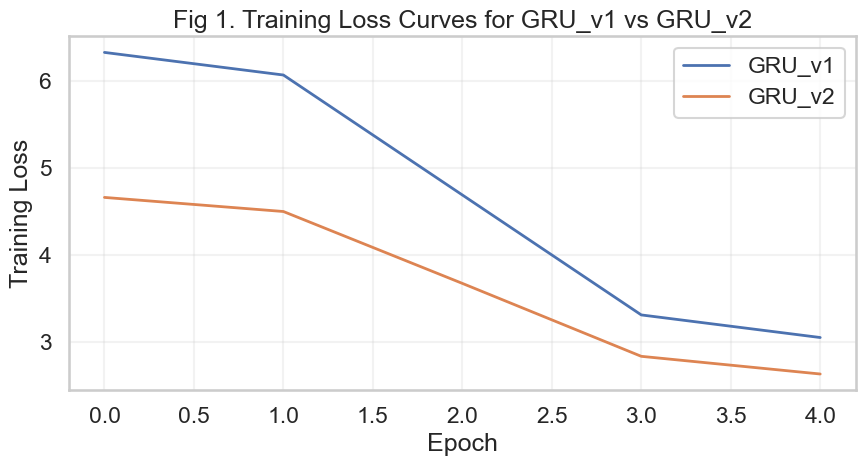

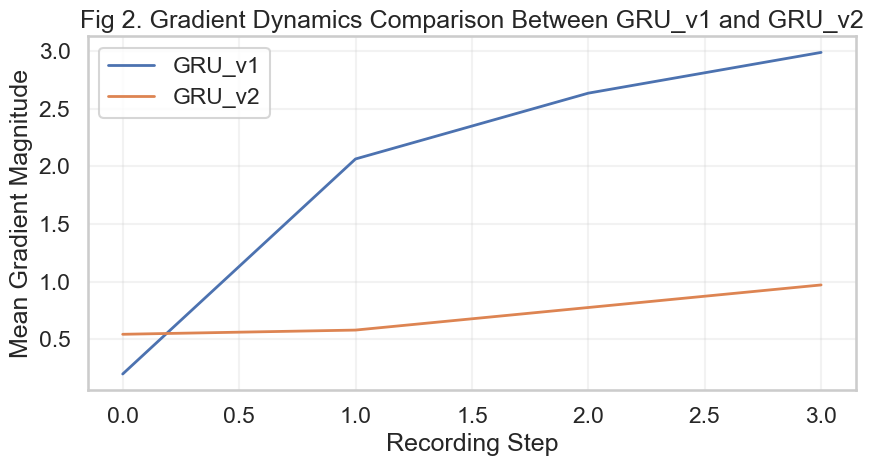

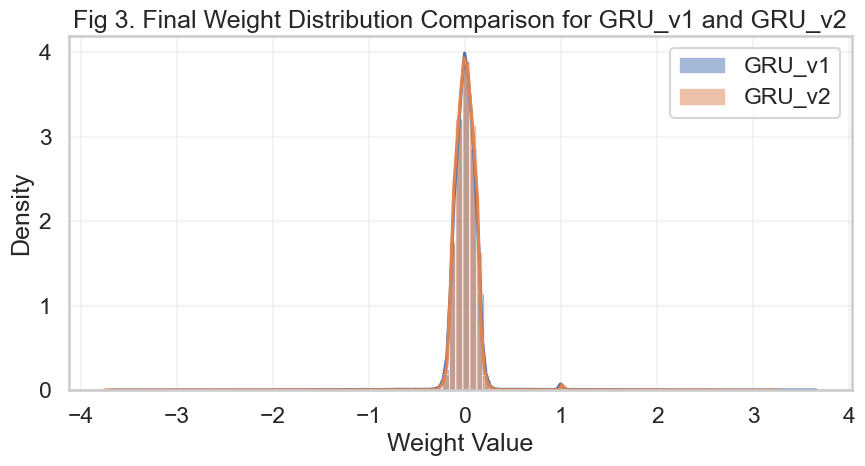

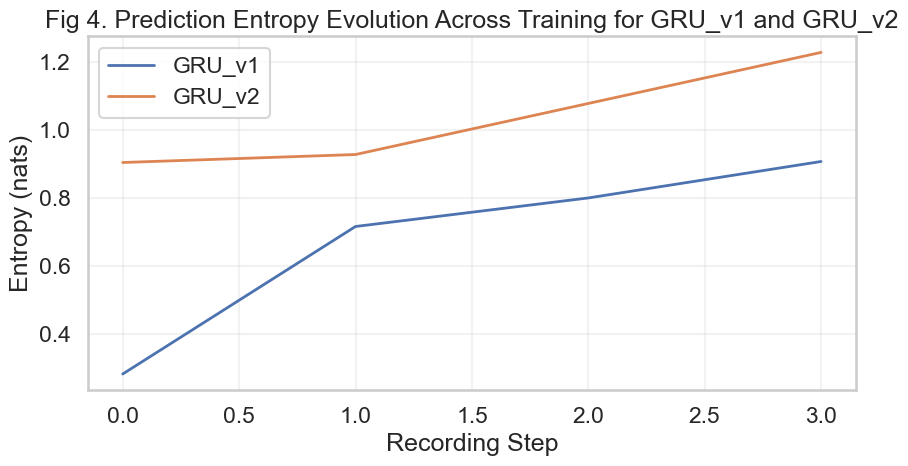

In [ ]:
plot_loss_curve(diag_v1, diag_v2, labels=("GRU_v1","GRU_v2"))
plot_gradient_flow(diag_v1, diag_v2, labels=("GRU_v1","GRU_v2"))
plot_weight_distribution(diag_v1, diag_v2, labels=("GRU_v1","GRU_v2"))
plot_entropy(diag_v1, diag_v2, labels=("GRU_v1","GRU_v2"))